In [44]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import umap.umap_ as umap
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [45]:
# Function to load MNIST images from idx file
def load_idx_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack('>IIII', f.read(16))  # Read metadata
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols, 1)  # Read images
    return data.astype(np.float32) / 255.0  # Normalize between 0 and 1

# Function to load MNIST labels from idx file
def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack('>II', f.read(8))  # Read metadata
        labels = np.frombuffer(f.read(), dtype=np.uint8)  # Read labels
    return labels

In [46]:
# Load train and test data
train_images = load_idx_images("train-images.idx3-ubyte")
train_labels = load_idx_labels("train-labels.idx1-ubyte")
test_images = load_idx_images("t10k-images.idx3-ubyte")
test_labels = load_idx_labels("t10k-labels.idx1-ubyte")

# Print dataset shapes
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (60000, 28, 28, 1)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28, 1)
Test Labels Shape: (10000,)


In [47]:
def residual_block(x, filters):
    skip = x  # Save input for skip connection
    
    if x.shape[-1] != filters:
        skip = layers.Conv2D(filters, (1, 1), padding='same', activation=None)(skip)
    
    x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, (3, 3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, skip])
    x = layers.ReLU()(x)
    return x

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder():
    input_img = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = residual_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)
    
    z_mean = layers.Dense(64, name='z_mean')(x)
    z_log_var = layers.Dense(64, name='z_log_var')(x)
    
    z = layers.Lambda(sampling, output_shape=(64,), name='z')([z_mean, z_log_var])
    
    return models.Model(input_img, [z_mean, z_log_var, z], name="VAE_Encoder")

def build_decoder():
    latent_input = layers.Input(shape=(64,))
    x = layers.Dense(256 * 7 * 7, activation='relu')(latent_input)
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(x)
    
    return models.Model(latent_input, x, name="VAE_Decoder")

encoder = build_encoder()
decoder = build_decoder()

input_img = encoder.input
z_mean, z_log_var, z = encoder(input_img)
reconstructed_img = decoder(z)

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def compute_loss(self, y_true, y_pred, z_mean, z_log_var):
        reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(y_true), K.flatten(y_pred))
        reconstruction_loss = K.mean(reconstruction_loss) * 28 * 28  # Scale loss
        
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_loss = K.mean(kl_loss)  # Take mean across batch

        return reconstruction_loss + kl_loss

    def train_step(self, data):
        # Unpack input images (ignore target images since they're the same for autoencoders)
        if isinstance(data, tuple):
            x, _ = data  # Take only the input images
        else:
            x = data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            loss = self.compute_loss(x, reconstruction, z_mean, z_log_var)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {"loss": loss}

# Rebuild VAE with the custom training step
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

vae.summary()
encoder.summary()
decoder.summary()

Model: "vae_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_Encoder (Functional)        │ [(None, 64), (None,    │     1,184,640 │
│                                 │ 64), (None, 64)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_Decoder (Functional)        │ (None, 28, 28, 1)      │     1,959,361 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,144,001 (11.99 MB)

 Trainable params: 3,142,465 (11.99 MB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "VAE_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 28, 28,    │        640 │ input_layer_30[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 14, 14,    │          0 │ conv2d_105[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 14, 14,    │     73,856 │ max_pooling2d_30… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_107[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_60 (ReLU)     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 14, 14,    │    147,584 │ re_lu_60[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_108[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 14, 14,    │      8,320 │ max_pooling2d_30… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_106[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_61 (ReLU)     │ (None, 14, 14,    │          0 │ add_33[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 7, 7, 128) │          0 │ re_lu_61[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 7, 7, 256) │    295,168 │ max_pooling2d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_110[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_62 (ReLU)     │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 7, 7, 256) │    590,080 │ re_lu_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_111[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 7, 7, 256) │     33,024 │ max_pooling2d_31

 Total params: 1,184,640 (4.52 MB)

 Trainable params: 1,183,104 (4.51 MB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "VAE_Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12544)          │       815,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_90             │ (None, 7, 7, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_91             │ (None, 7, 7, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_30 (UpSampling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_92             │ (None, 14, 14, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_93             │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_31 (UpSampling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_94             │ (None, 28, 28, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_95             │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,959,361 (7.47 MB)

 Trainable params: 1,959,361 (7.47 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train the VAE
vae.fit(train_images, train_images, epochs=5, batch_size=32, shuffle=True)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 153s 80ms/step - loss: 151.7152
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 151s 81ms/step - loss: 112.4932
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 151s 80ms/step - loss: 106.8511
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 149s 79ms/step - loss: 103.7048
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 149s 79ms/step - loss: 101.5704


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


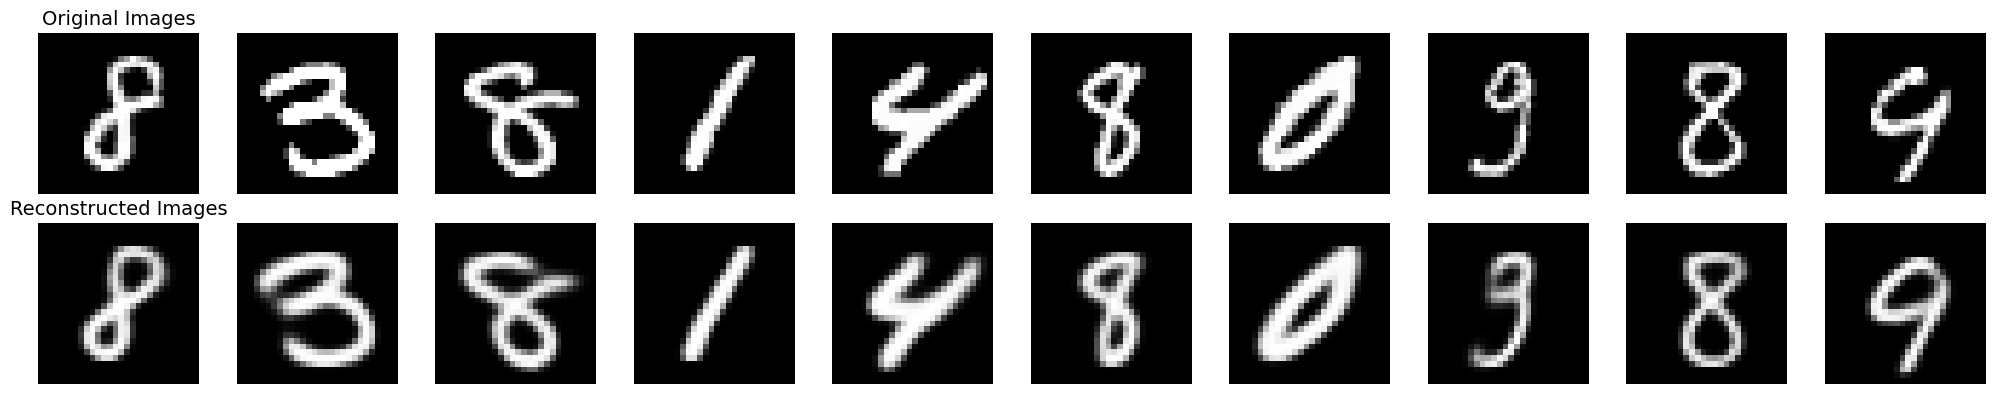

In [50]:
# Select random images from the dataset
num_images = 10  # Number of images to display
random_indices = np.random.choice(len(train_images), num_images, replace=False)

# Encode and decode the images
encoded_imgs = encoder.predict(train_images[random_indices])  # Pass through encoder
decoded_imgs = decoder.predict(encoded_imgs[0])  # Pass through decoder

# Plot the images: original vs. reconstructed
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

for i in range(num_images):
    # Original images
    axes[0, i].imshow(train_images[random_indices[i]].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original Images", fontsize=14)
axes[1, 0].set_title("Reconstructed Images", fontsize=14)
plt.tight_layout()
plt.show()

In [65]:
# Extract Features Using Encoder
encoded_train = encoder.predict(train_images)[0]
encoded_test = encoder.predict(test_images)[0]

# Reduce to 5D using UMAP
umap_5d = umap.UMAP(n_components=8, random_state=42)
encoded_train_5d = umap_5d.fit_transform(encoded_train)
encoded_test_5d = umap_5d.transform(encoded_test)

num_clusters = 16  # Adjust based on variation in styles
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
gmm.fit(encoded_train_5d)

# Assign clusters to training and test data
train_clusters = gmm.predict(encoded_train_5d)
test_clusters = gmm.predict(encoded_test_5d)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [66]:
from scipy.stats import mode

# Assign labels to clusters based on most frequent digit
def assign_labels(clusters, true_labels):
    label_map = {}
    for i in range(num_clusters):
        mask = (clusters == i)  # Select points in cluster i
        if np.sum(mask) == 0:
            label_map[i] = -1  # No samples in cluster
        else:
            most_common = mode(true_labels[mask])[0]  # Most frequent digit
            label_map[i] = most_common
    return label_map

cluster_to_label = assign_labels(train_clusters, train_labels)
predicted_labels = np.array([cluster_to_label[c] for c in test_clusters])

# Evaluate Clustering Performance
accuracy = np.mean(predicted_labels == test_labels)
print(f"GMM Classification Accuracy: {accuracy * 100:.2f}%")


GMM Classification Accuracy: 96.41%


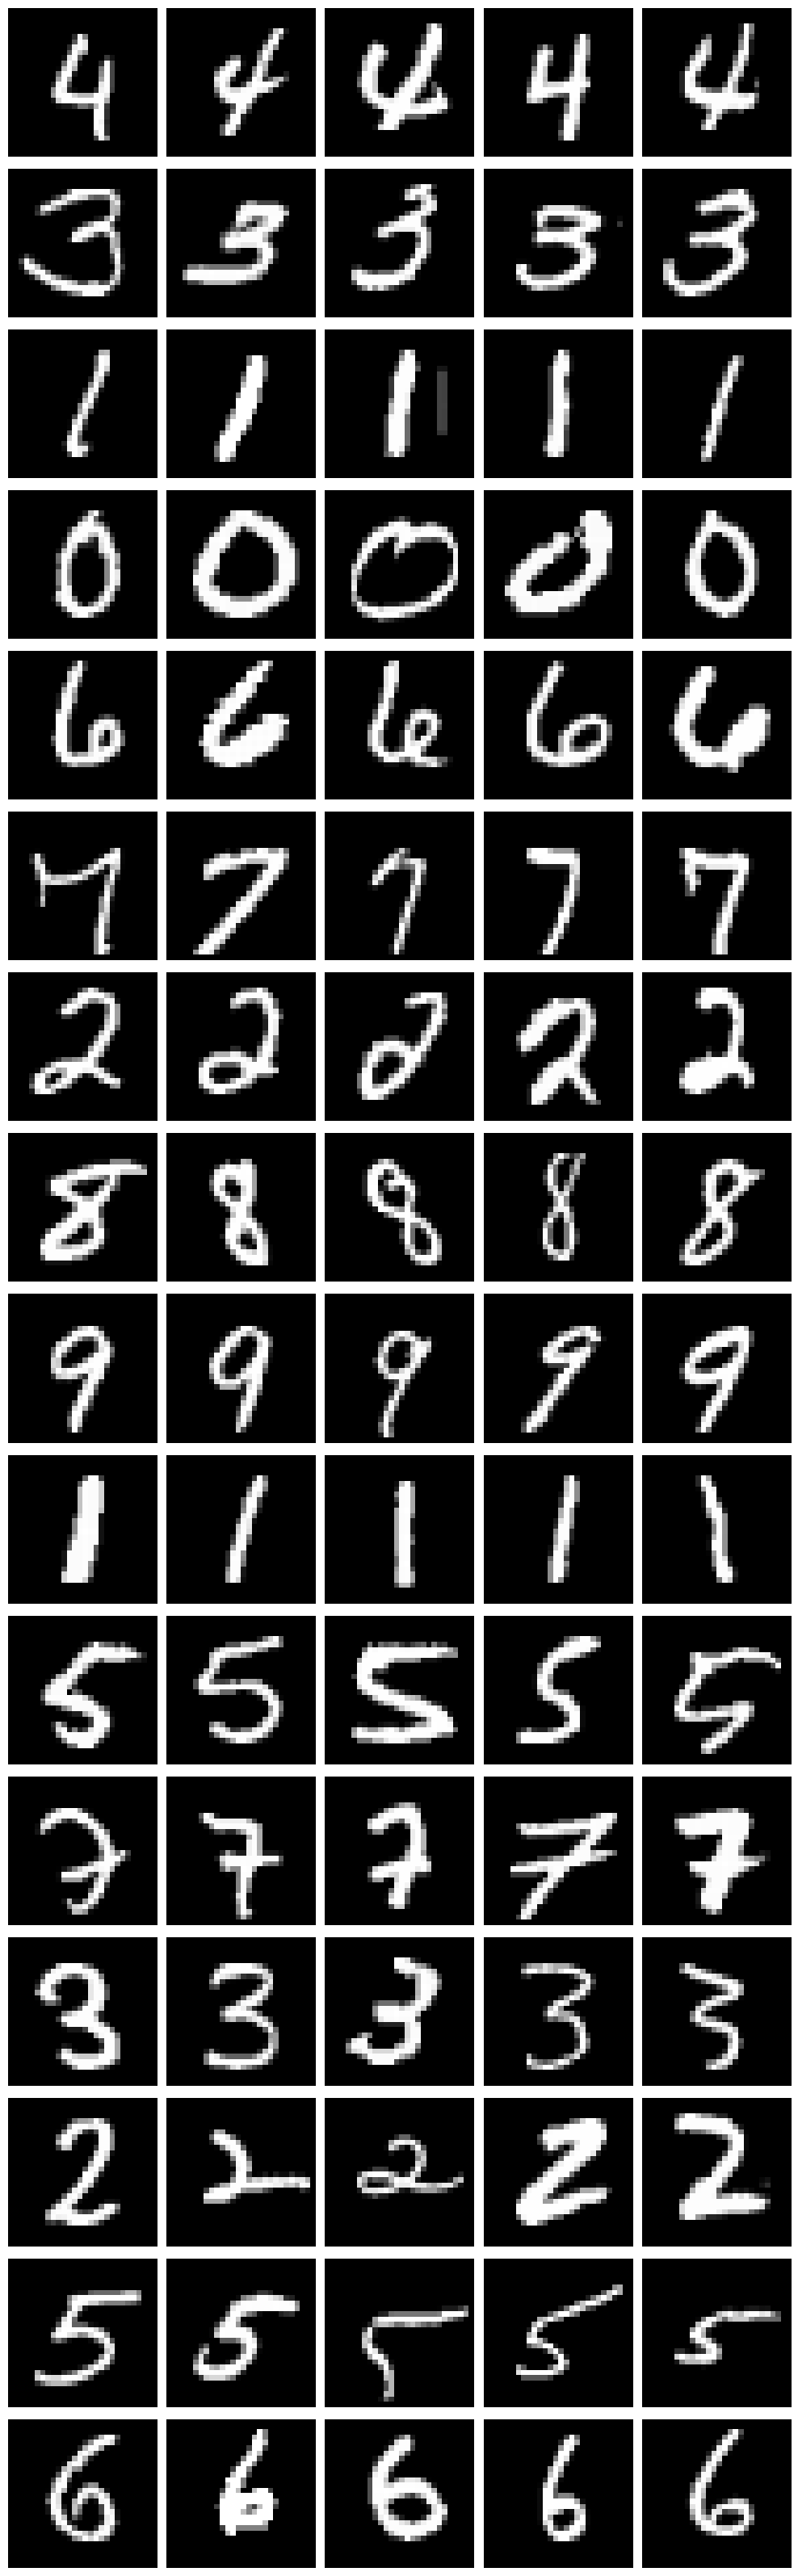

In [67]:
# Function to plot samples from each cluster
def plot_cluster_samples(images, cluster_labels, num_samples=5):
    unique_clusters = np.unique(cluster_labels)
    fig, axes = plt.subplots(len(unique_clusters), num_samples, figsize=(num_samples * 2, len(unique_clusters) * 2))
    
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, min(num_samples, len(cluster_indices)), replace=False)
        
        for j, img_idx in enumerate(selected_indices):
            axes[i, j].imshow(images[img_idx].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display images
plot_cluster_samples(train_images, train_clusters, num_samples=5)

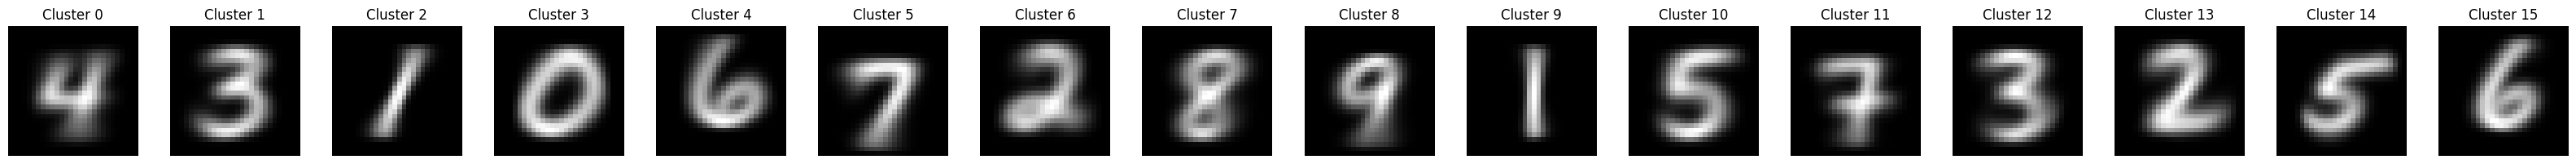

In [68]:
def plot_average_images(images, cluster_labels, num_clusters):
    
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 2, 2))

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices for the cluster
        if len(cluster_indices) > 0:
            avg_image = np.mean(images[cluster_indices], axis=0)  # Compute mean image
        else:
            avg_image = np.zeros_like(images[0])  # Handle empty clusters

        axes[cluster].imshow(avg_image.reshape(28, 28), cmap='gray')
        axes[cluster].axis('off')
        axes[cluster].set_title(f"Cluster {cluster}")

    plt.tight_layout()
    plt.show()

# Call function to display average images from clusters
plot_average_images(train_images, train_clusters, num_clusters)

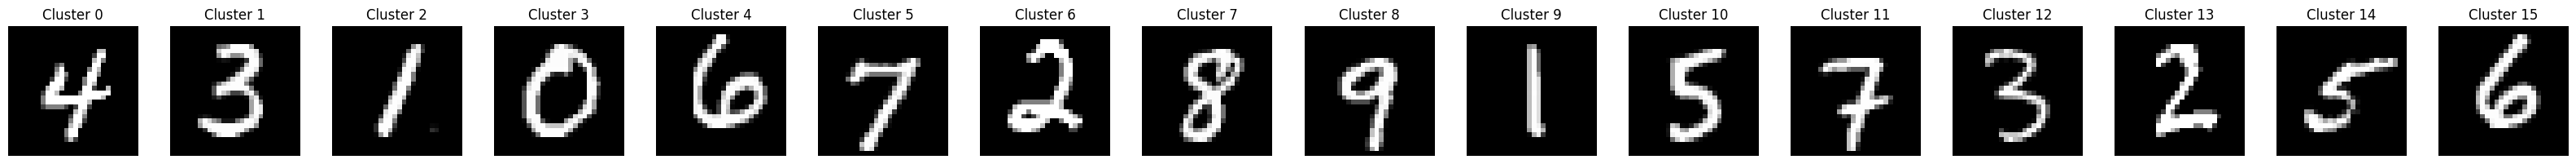

In [69]:
from scipy.spatial.distance import cdist

def find_representative_images(encoded_images, images, cluster_labels, num_clusters):
    """
    Finds and plots the most representative image from each cluster.
    """
    representative_images = []

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices for the cluster
        if len(cluster_indices) == 0:
            representative_images.append(np.zeros_like(images[0]))  # Empty cluster placeholder
            continue

        cluster_features = encoded_images[cluster_indices]  # Get encoded features for cluster
        centroid = np.mean(cluster_features, axis=0)  # Compute centroid
        distances = cdist([centroid], cluster_features, metric="euclidean")  # Compute distances
        closest_index = cluster_indices[np.argmin(distances)]  # Find closest image index

        representative_images.append(images[closest_index])  # Store representative image

    # Plot representative images
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 2, 2))
    for i in range(num_clusters):
        axes[i].imshow(representative_images[i].reshape(28, 28), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Cluster {i}")

    plt.tight_layout()
    plt.show()

# Call function to display representative images
find_representative_images(encoded_train, train_images, train_clusters, num_clusters)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


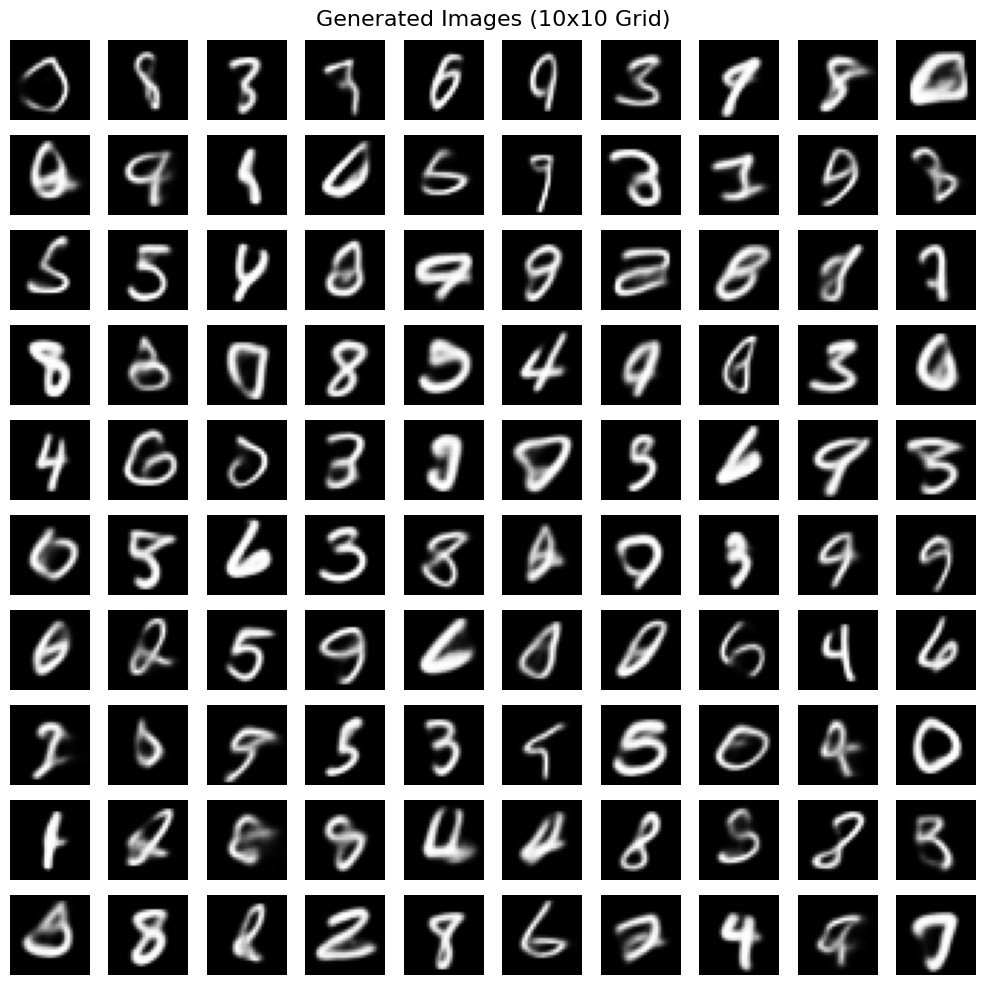

In [78]:
generated_images = []

# Sample latent vectors from a standard normal distribution
new_latents = np.random.normal(size=(100, 64))  # 16 is the latent space dimension

# Decode into images
new_images = decoder.predict(new_latents)

new_images = np.squeeze(new_images)
# Create a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        idx = i * 10 + j  # Compute the index in the flattened array
        axes[i, j].imshow(new_images[idx], cmap='gray')
        axes[i, j].axis('off')

plt.suptitle("Generated Images (10x10 Grid)", fontsize=16)
plt.tight_layout()
plt.show()


In [79]:
generated_images = []  # Store generated images per cluster

for cluster in range(num_clusters):
    cluster_indices = np.where(train_clusters == cluster)[0]  # Get indices for this cluster

    if len(cluster_indices) == 0:
        continue  # Skip empty clusters

    # Fine-tune VAE on this cluster (low learning rate, few epochs)
    vae.fit(train_images[cluster_indices], train_images[cluster_indices], epochs=3, batch_size=16, shuffle=True)

    # Generate new latent vectors
    new_latents = np.random.normal(size=(100, 64))  # Adjust latent dimension

    # Decode into images
    new_images = decoder.predict(new_latents)
    generated_images.append(new_images)

generated_images = np.array(generated_images)  # Convert to NumPy array

Epoch 1/3
362/362 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - loss: 100.7427
Epoch 2/3
362/362 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - loss: 96.5366
Epoch 3/3
362/362 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - loss: 94.7302
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/3
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 111.3843
Epoch 2/3
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 105.9089
Epoch 3/3
275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - loss: 104.0641
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/3
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - loss: 54.8929
Epoch 2/3
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 50.8417
Epoch 3/3
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - loss: 49.7540
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/3
373/373 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - loss: 114.6376
Epoch 2/3
373/373 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - loss: 107.8186
Epoch 3/3
373/373 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - loss: 106.0867
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/3
144

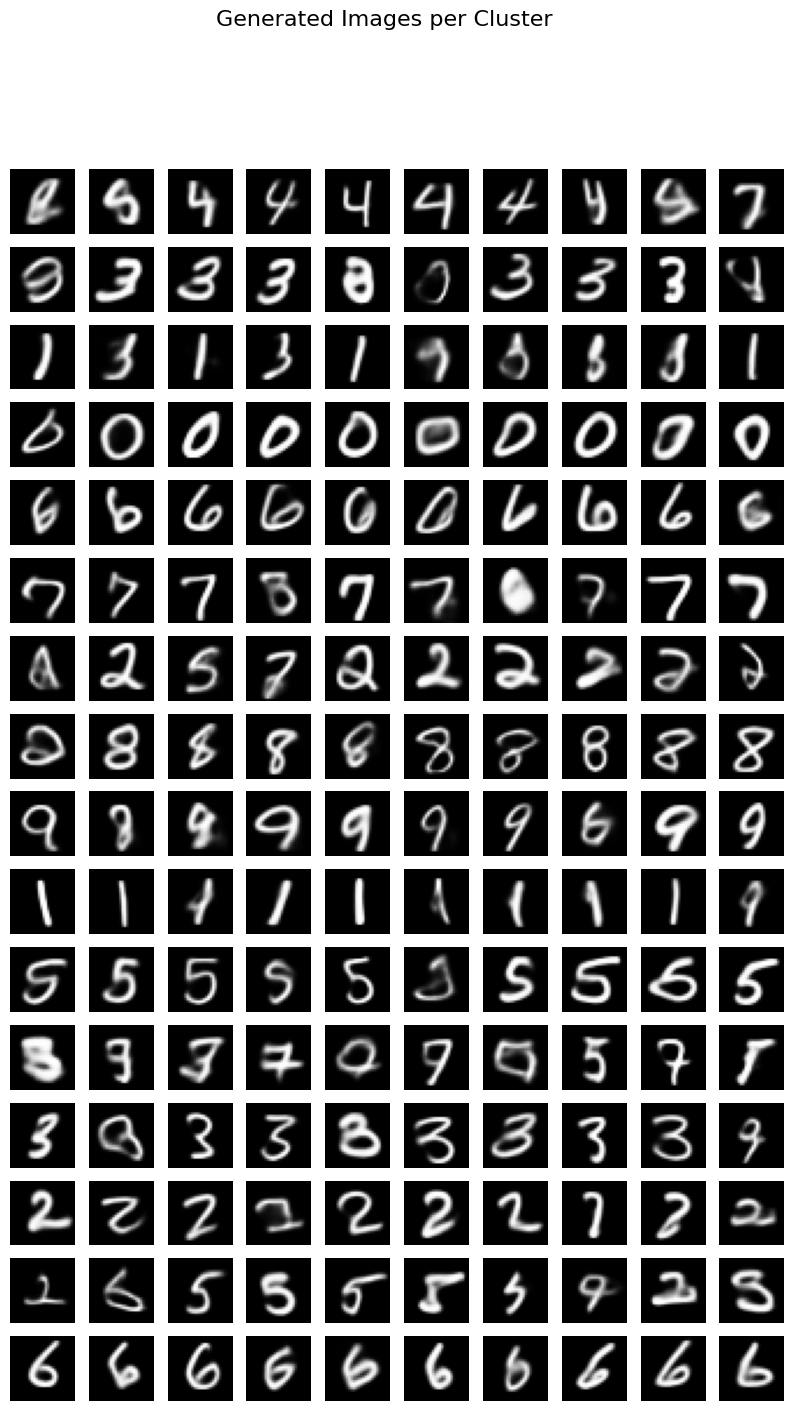

In [81]:
# Define the figure size
fig, axes = plt.subplots(num_clusters, 10, figsize=(10, num_clusters))

# Loop through clusters and plot the images
for cluster in range(num_clusters):
    for i in range(10):  # 10 images per row
        axes[cluster, i].imshow(generated_images[cluster][i].squeeze(), cmap='gray')
        axes[cluster, i].axis('off')  # Hide axes

# Set title
plt.suptitle("Generated Images per Cluster", fontsize=16)
plt.show()

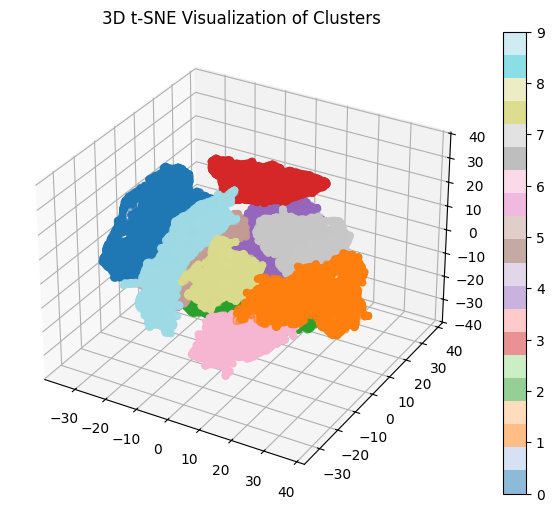

In [ ]:
# Reduce from 5D to 3D for visualization
tsne_3d = TSNE(n_components=3, random_state=42)
reduced_3d = tsne_3d.fit_transform(encoded_train_5d)

# Plot 3D scatter of clusters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_3d[:, 0], reduced_3d[:, 1], reduced_3d[:, 2], c=train_clusters, cmap='tab20', alpha=0.5)
plt.colorbar(scatter)
plt.title("3D t-SNE Visualization of Clusters")
plt.show()